# Measure waveforms

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qubecalib import QubeCalib
from qubecalib.neopulse import (
    Capture,
    Flushleft,
    RaisedCosFlatTop,
    Rectangle,
    Sequence,
    Series,
)

In [2]:
%matplotlib inline

In [3]:
# load the wiring settings
qc = QubeCalib("./wiring_settings.json")

In [4]:
# check the settings
qc.system_config_database.asdict()

{'clockmaster_setting': None,
 'box_settings': {'A25': {'ipaddr_wss': '10.1.0.25',
   'ipaddr_sss': '10.2.0.25',
   'ipaddr_css': '10.5.0.25',
   'boxtype': <Quel1BoxType.QuBE_RIKEN_TypeA: ('qube', 'riken-type-a')>,
   'config_root': None,
   'config_options': []},
  'A73': {'ipaddr_wss': '10.1.0.73',
   'ipaddr_sss': '10.2.0.73',
   'ipaddr_css': '10.5.0.73',
   'boxtype': <Quel1BoxType.QuEL1_TypeA: ('quel-1', 'type-a')>,
   'config_root': None,
   'config_options': []}},
 'box_aliases': {},
 'port_settings': {'A25.P0': {'port_name': 'A25.P0',
   'box_name': 'A25',
   'port': 0,
   'ndelay_or_nwait': [0]},
  'A25.P1': {'port_name': 'A25.P1',
   'box_name': 'A25',
   'port': 1,
   'ndelay_or_nwait': [0, 0, 0, 0]},
  'A25.P2': {'port_name': 'A25.P2',
   'box_name': 'A25',
   'port': 2,
   'ndelay_or_nwait': []},
  'A25.P3': {'port_name': 'A25.P3',
   'box_name': 'A25',
   'port': 3,
   'ndelay_or_nwait': []},
  'A25.P4': {'port_name': 'A25.P4',
   'box_name': 'A25',
   'port': 4,
   'nd

In [5]:
box_list = ["A25", "A73"]

boxes = {}
for box_name in box_list:
    box = qc.create_box(box_name, reconnect=False)
    if not all(box.link_status().values()):
        box.relinkup(use_204b=False, background_noise_threshold=400)
    box.reconnect()
    boxes[box_name] = box
    print(box_name, box.link_status())

A25 {0: True, 1: True}
A73 {0: True, 1: True}


In [6]:
for box in boxes.values():
    print(box.dump_box())

{'mxfes': {0: {'channel_interporation_rate': 4, 'main_interporation_rate': 6}, 1: {'channel_interporation_rate': 4, 'main_interporation_rate': 6}}, 'ports': {0: {'direction': 'out', 'channels': {0: {'fnco_freq': 0.0}}, 'cnco_freq': 1968750000.0, 'fullscale_current': 40527, 'lo_freq': 8500000000, 'sideband': 'U', 'rfswitch': 'pass'}, 1: {'direction': 'in', 'lo_freq': 8500000000, 'cnco_freq': 1968750000.0, 'rfswitch': 'open', 'runits': {0: {'fnco_freq': 0.0}, 1: {'fnco_freq': 0.0}, 2: {'fnco_freq': 0.0}, 3: {'fnco_freq': 0.0}}}, 2: {'direction': 'out', 'channels': {0: {'fnco_freq': 0.0}}, 'cnco_freq': 1500000000.0, 'fullscale_current': 40527, 'lo_freq': 11000000000, 'sideband': 'U', 'rfswitch': 'block'}, 4: {'direction': 'in', 'lo_freq': 11000000000, 'cnco_freq': 1500000000.0, 'rfswitch': 'loop', 'runits': {0: {'fnco_freq': 0.0}}}, 5: {'direction': 'out', 'channels': {0: {'fnco_freq': 0.0}, 1: {'fnco_freq': 0.0}, 2: {'fnco_freq': 0.0}}, 'cnco_freq': 1710937500.0, 'fullscale_current': 405

## Capture noise

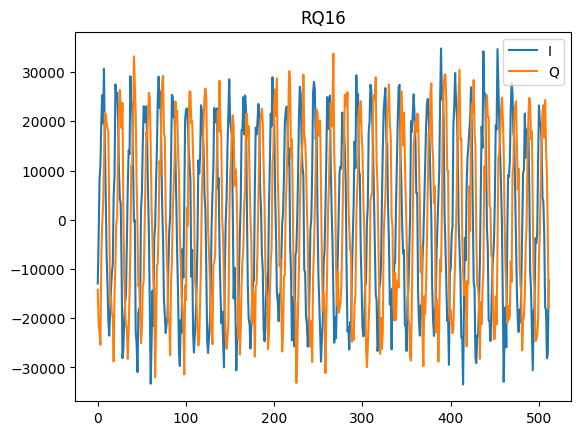

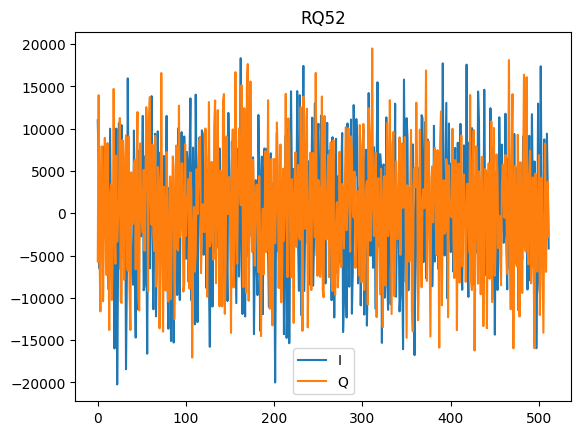

In [7]:
capture = Capture(duration=1024)

with Sequence() as seq:
    with Flushleft():
        capture.target("RQ16")
        capture.target("RQ52")

qc.add_sequence(seq)

for status, data, config in qc.step_execute(
    repeats=1000,
    dsp_demodulation=False,
):
    for target, iqs in data.items():
        iq = iqs[0].squeeze()
        plt.plot(np.real(iq), label="I")
        plt.plot(np.imag(iq), label="Q")
        plt.title(target)
        plt.legend()
        plt.show()

## Capture reflected waveforms

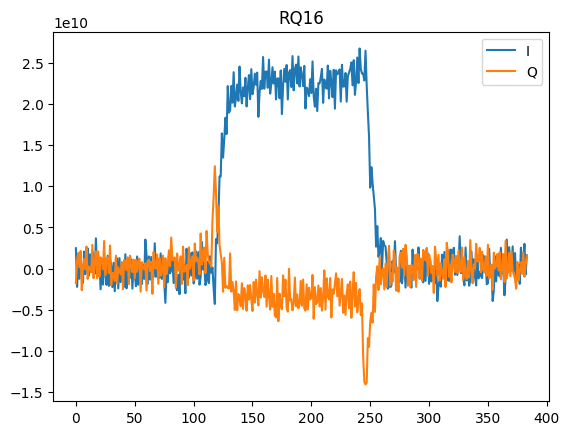

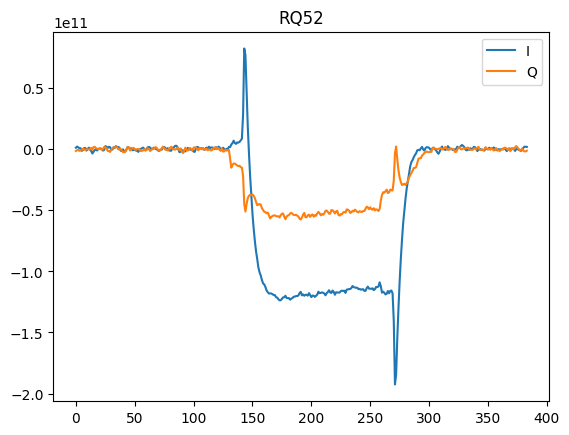

In [8]:
pulse = Rectangle(duration=1024, amplitude=0.1)
capture = Capture(duration=3 * 1024)

with Sequence() as seq:
    with Flushleft():
        pulse.scaled(0.5).target("RQ16")
        pulse.shifted(np.pi).scaled(3).target("RQ52")
        capture.target("RQ16", "RQ52")

qc.add_sequence(seq)

for status, data, config in qc.step_execute(
    repeats=3000,
    interval=150 * 1024,
):
    for target, iqs in data.items():
        iq = iqs[0].squeeze()
        plt.plot(np.real(iq), label="I")
        plt.plot(np.imag(iq), label="Q")
        plt.title(target)
        plt.legend()
        plt.show()

### Multiplexed

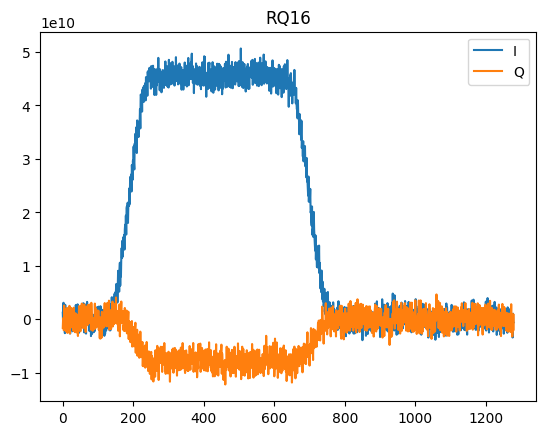

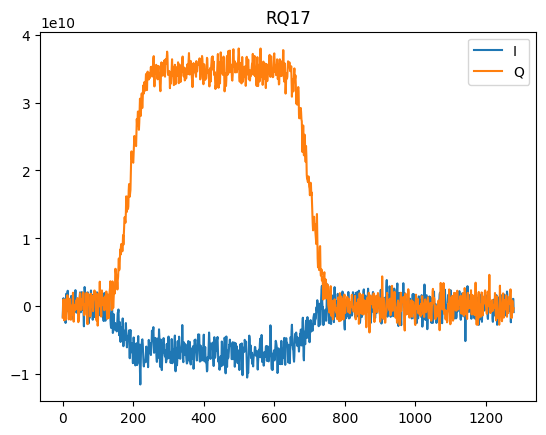

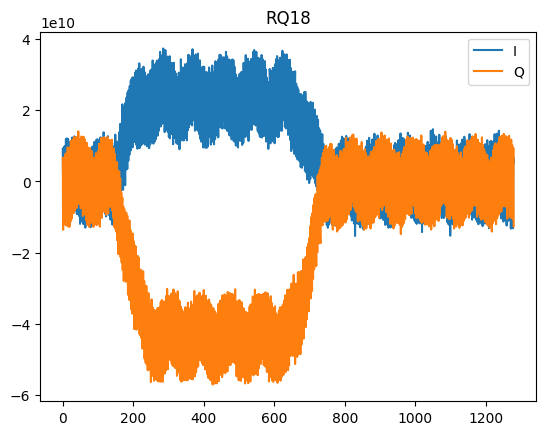

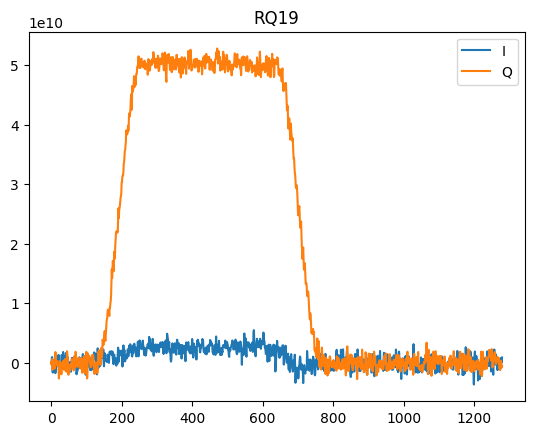

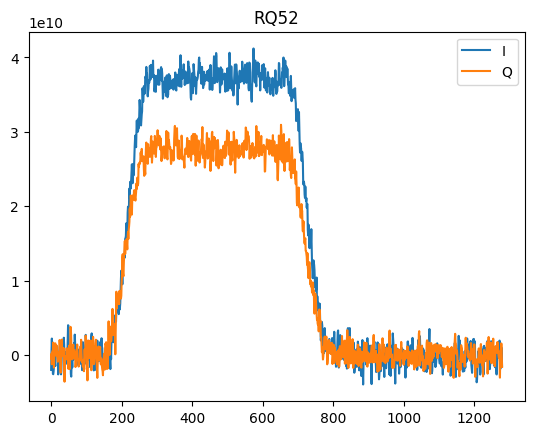

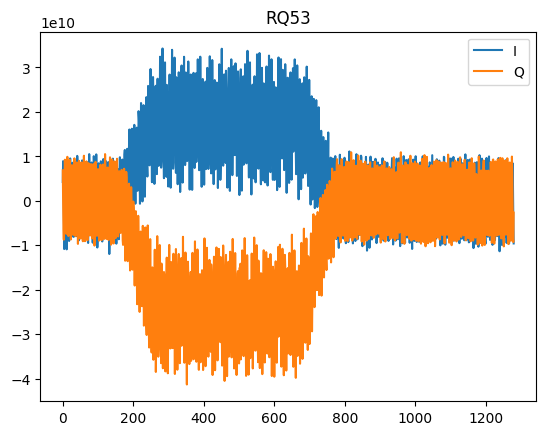

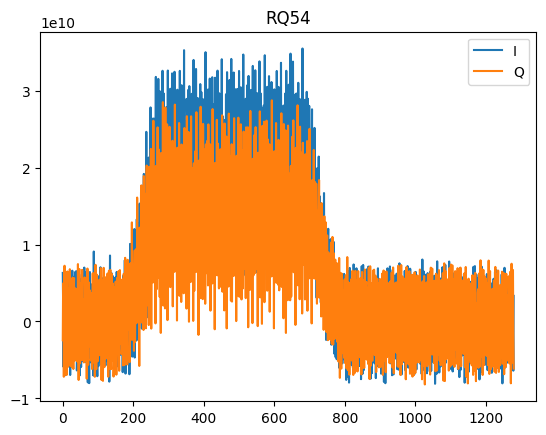

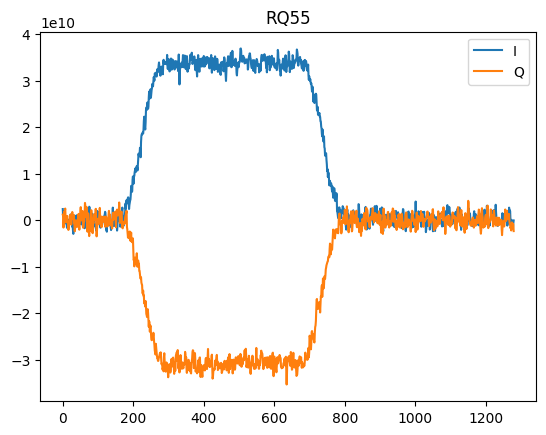

In [9]:
pulse = RaisedCosFlatTop(duration=5 * 1024, amplitude=0.1, rise_time=1024)
capture = Capture(duration=10 * 1024)

with Sequence() as seq:
    with Flushleft():
        pulse.target("RQ16", "RQ17", "RQ18", "RQ19", "RQ52", "RQ53", "RQ54", "RQ55")
        capture.target("RQ16", "RQ17", "RQ18", "RQ19", "RQ52", "RQ53", "RQ54", "RQ55")

qc.add_sequence(seq)

for status, data, config in qc.step_execute(
    repeats=3000,
    interval=150 * 1024,
):
    for target, iqs in data.items():
        iq = iqs[0].squeeze()
        plt.plot(np.real(iq), label="I")
        plt.plot(np.imag(iq), label="Q")
        plt.title(target)
        plt.legend()
        plt.show()

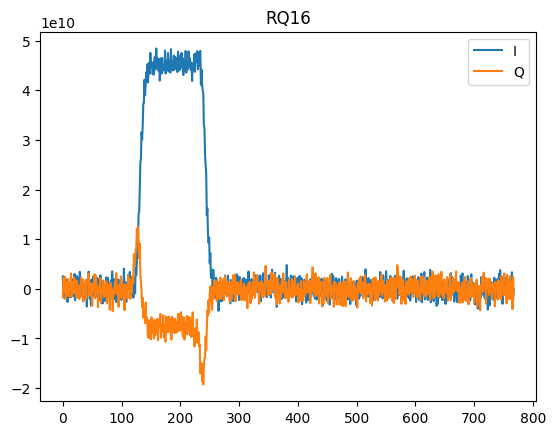

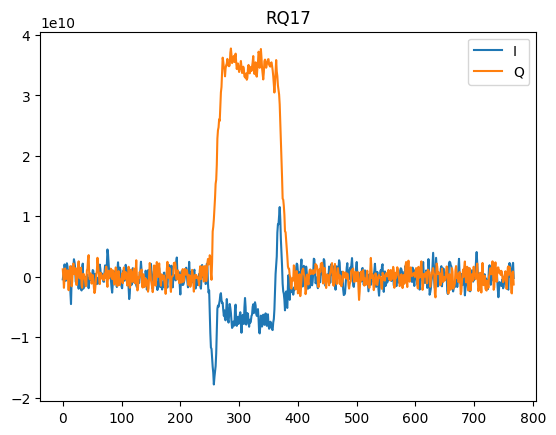

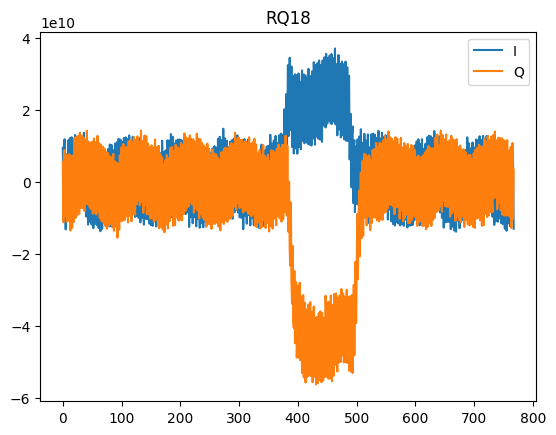

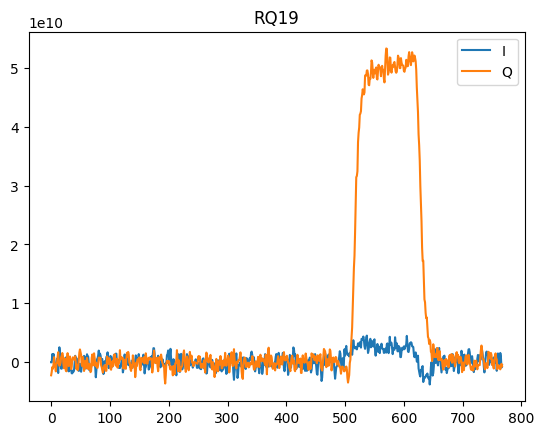

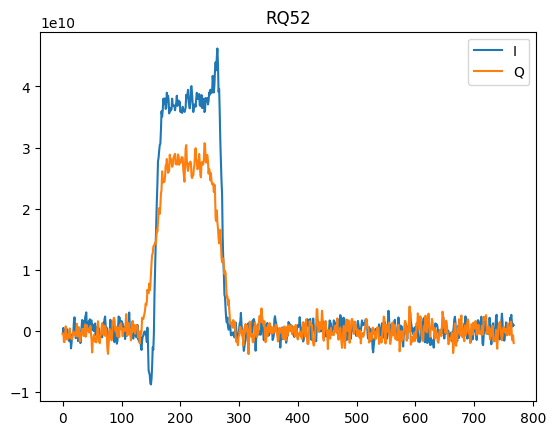

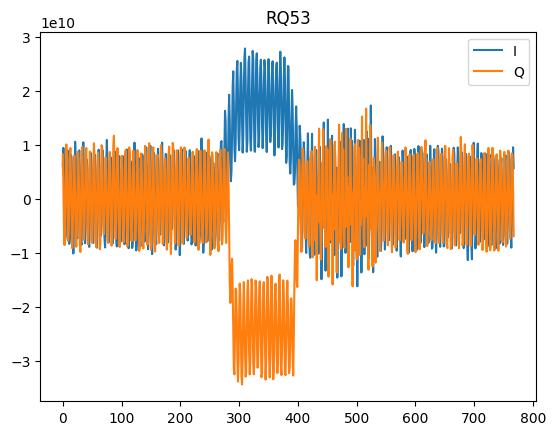

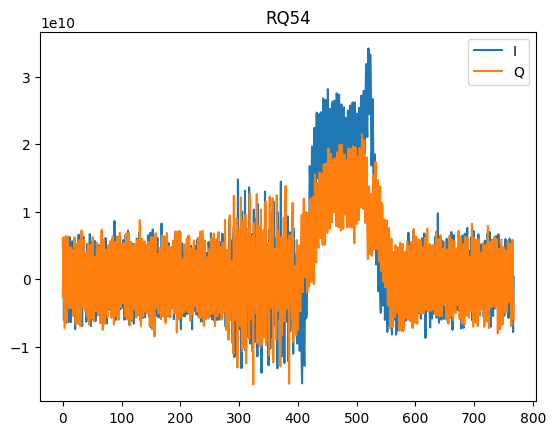

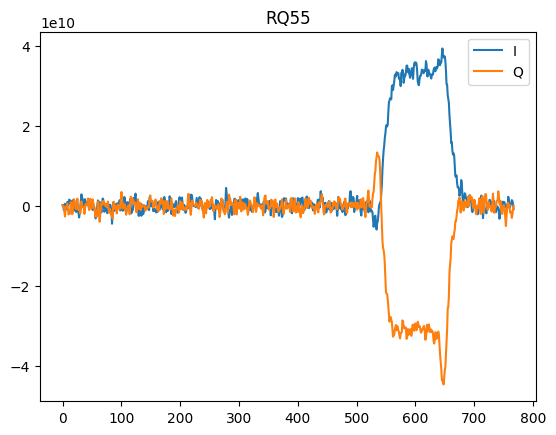

In [10]:
pulse = RaisedCosFlatTop(duration=1024, amplitude=0.1, rise_time=128)
capture = Capture(duration=6 * 1024)

with Sequence() as seq:
    with Flushleft():
        with Series():
            pulse.target("RQ16")
            pulse.target("RQ17")
            pulse.target("RQ18")
            pulse.target("RQ19")
        with Series():
            pulse.target("RQ52")
            pulse.target("RQ53")
            pulse.target("RQ54")
            pulse.target("RQ55")
        capture.target("RQ16", "RQ17", "RQ18", "RQ19", "RQ52", "RQ53", "RQ54", "RQ55")

qc.add_sequence(seq)

for status, data, config in qc.step_execute(
    repeats=3000,
    interval=150 * 1024,
):
    for target, iqs in data.items():
        iq = iqs[0].squeeze()
        plt.plot(np.real(iq), label="I")
        plt.plot(np.imag(iq), label="Q")
        plt.title(target)
        plt.legend()
        plt.show()